In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_workers = 0
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

tensor(6)


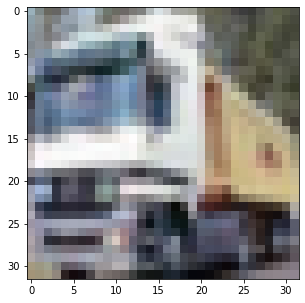

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

print(labels[0])
img = np.squeeze(images[1]).transpose(1, 2, 0)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # div size by 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 3, 3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def decode(self, x):
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        return x
        
    def forward(self, x):

        x = self.encode(x)
        x = self.decode(x)
                
        return x

model = ConvAutoencoder()
model = model.cuda()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
n_epochs = 30
for epoch in range(1, n_epochs+1):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data
        # add noise as regularisation
        images += torch.from_numpy(np.random.randn(100, 3, 32, 32) * 40/255)
        images = images.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


/usr/lib/python3.8/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 4.226282
Epoch: 2 	Training Loss: 3.365006
Epoch: 3 	Training Loss: 3.269778
Epoch: 4 	Training Loss: 3.218437
Epoch: 5 	Training Loss: 3.176240
Epoch: 6 	Training Loss: 3.137549
Epoch: 7 	Training Loss: 3.118817
Epoch: 8 	Training Loss: 3.106374
Epoch: 9 	Training Loss: 3.097020
Epoch: 10 	Training Loss: 3.089844
Epoch: 11 	Training Loss: 3.083646
Epoch: 12 	Training Loss: 3.078731
Epoch: 13 	Training Loss: 3.074681
Epoch: 14 	Training Loss: 3.071037
Epoch: 15 	Training Loss: 3.066054
Epoch: 16 	Training Loss: 3.063113
Epoch: 17 	Training Loss: 3.059688
Epoch: 18 	Training Loss: 3.056115
Epoch: 19 	Training Loss: 3.053266
Epoch: 20 	Training Loss: 3.050246
Epoch: 21 	Training Loss: 3.047128
Epoch: 22 	Training Loss: 3.044749
Epoch: 23 	Training Loss: 3.042020
Epoch: 24 	Training Loss: 3.038789
Epoch: 25 	Training Loss: 3.037629
Epoch: 26 	Training Loss: 3.035236
Epoch: 27 	Training Loss: 3.033756
Epoch: 28 	Training Loss: 3.031411
Epoch: 29 	Training Loss: 3.0

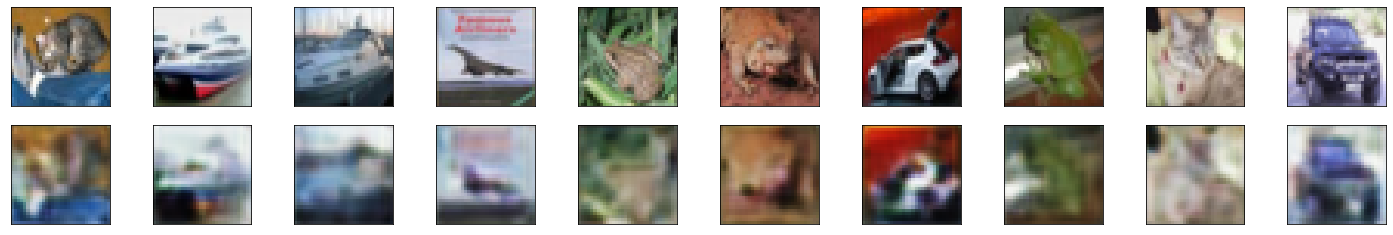

In [8]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()

output = model(images)

images = images.cpu().numpy()

output = output.view(batch_size, 3, 32, 32)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img).transpose(1, 2, 0), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

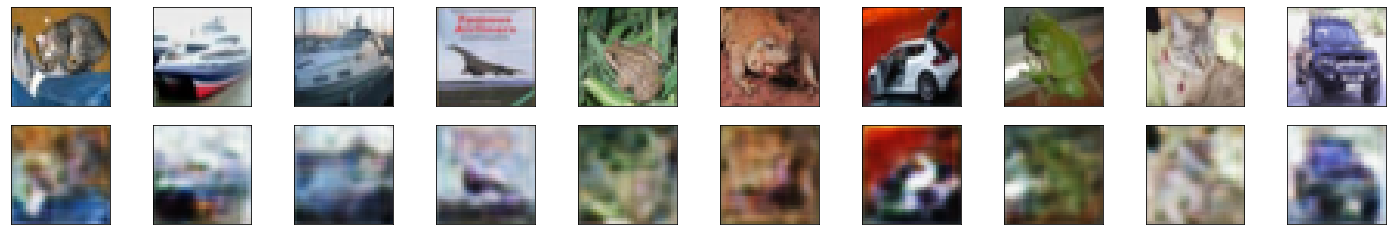

In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()

encode = model.encode(images).cuda().float()
encode += torch.from_numpy(np.random.randn(100, 4, 8, 8) * 0.1).cuda()
output = model.decode(encode)

images = images.cpu().numpy()

output = output.view(batch_size, 3, 32, 32)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img).transpose(1, 2, 0), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

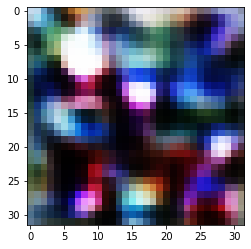

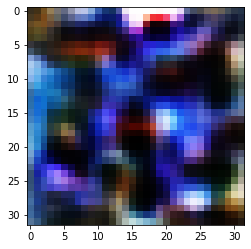

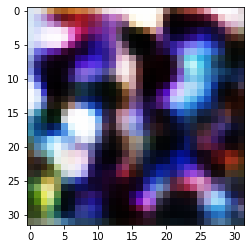

In [14]:
output = model.decode(torch.from_numpy(np.abs(np.random.randn(batch_size, 4, 8, 8)*1.5)).cuda().float())
output = output.view(batch_size, 3, 32, 32)
output = output.detach().cpu().numpy()
for i in range(3):
    plt.imshow(np.squeeze(output[i]).transpose(1, 2, 0), cmap='gray')
    plt.show()